In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

Duplicate key in file PosixPath('/opt/conda/lib/python3.8/site-packages/matplotlib/mpl-data/matplotlibrc'), line 758 ('font.family : NanumGothicCoding')


In [77]:
df = pd.read_csv('./medical_noshow.csv')  
df

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110522,2.572134e+12,5651768,F,2016-05-03T09:15:35Z,2016-06-07T00:00:00Z,56,MARIA ORTIZ,0,0,0,0,0,1,No
110523,3.596266e+12,5650093,F,2016-05-03T07:27:33Z,2016-06-07T00:00:00Z,51,MARIA ORTIZ,0,0,0,0,0,1,No
110524,1.557663e+13,5630692,F,2016-04-27T16:03:52Z,2016-06-07T00:00:00Z,21,MARIA ORTIZ,0,0,0,0,0,1,No
110525,9.213493e+13,5630323,F,2016-04-27T15:09:23Z,2016-06-07T00:00:00Z,38,MARIA ORTIZ,0,0,0,0,0,1,No


In [78]:
df.info() #결측치 없음.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


- PatientId : 환자 식별자
- AppointmentID : 예약 식별자
- Gender : 성별
- ScheduledDay : 예약을 등록하거나 전화로 예약한 날짜
- AppointmentDay : 실제 예약된 날짜
- Age : 환자 나이
- Neighbourhood : 예약한 병원 지역
- Scholarship : 저소득 가정에게 제공하는 장학금 프로그램 가입 여부
- Hipertension : 고혈압 여부
- Diabetes : 당뇨병 여부
- Alcoholism : 알코올 중독 여부
- Handcap : 장애 여부
- SMS_received : 환자에게 보낸 메시지 수
- No-show : 진료 불이행 여부

In [79]:
# 'No-show'비율 확인
no_show_counts = df['No-show'].value_counts()
no_show_counts

No     88208
Yes    22319
Name: No-show, dtype: int64

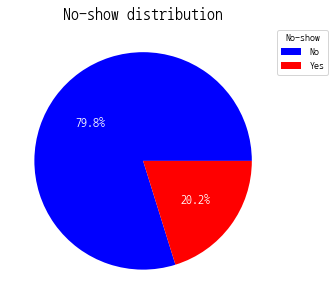

In [80]:
# 파이 차트 
plt.figure(figsize=(5,5))
wedges, texts, autotexts = plt.pie(no_show_counts, 
                                   labels = no_show_counts.index, 
                                   autopct=lambda p: '{:.1f}%'.format(p), 
                                   colors=['blue', 'red'], 
                                   textprops={'color':'white', 'fontsize': 12})

# 범례 추가
plt.legend(wedges, no_show_counts.index,
           title="No-show",
           #loc="center left",
           bbox_to_anchor=(1, 0, 0.2, 1))

plt.setp(autotexts, size=12, color='white')  # 파이 차트 안의 텍스트 크기와 색상 설정
plt.title('No-show distribution', fontsize=16)  # 그래프 제목
plt.show()

## 데이터 전처리 - Age 이상치 처리

In [81]:
df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


- Age min값 -1 존재 -> 전처리 필요

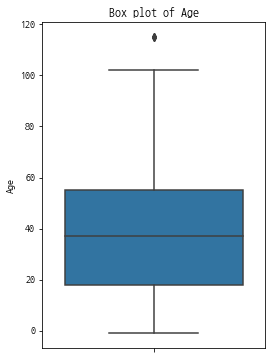

In [86]:
plt.figure(figsize=(4, 6))
sns.boxplot(y='Age', data=df)
plt.title('Box plot of Age')
plt.show()

- 현재 Age -1~ 115 존재 하여 이상치 제거

In [85]:
print(len(df[(df.Age < 0) | (df.Age > 100)]))
df[(df.Age < 0) | (df.Age > 100)]

8


,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
58014,9.762948e+14,5651757,F,2016-05-03T09:14:53Z,2016-05-03T00:00:00Z,102,CONQUISTA,0,0,0,0,0,0,No
63912,3.196321e+13,5700278,F,2016-05-16T09:17:44Z,2016-05-19T00:00:00Z,115,ANDORINHAS,0,0,0,0,1,0,Yes
63915,3.196321e+13,5700279,F,2016-05-16T09:17:44Z,2016-05-19T00:00:00Z,115,ANDORINHAS,0,0,0,0,1,0,Yes
68127,3.196321e+13,5562812,F,2016-04-08T14:29:17Z,2016-05-16T00:00:00Z,115,ANDORINHAS,0,0,0,0,1,0,Yes
76284,3.196321e+13,5744037,F,2016-05-30T09:44:51Z,2016-05-30T00:00:00Z,115,ANDORINHAS,0,0,0,0,1,0,No
90372,2.342836e+11,5751563,F,2016-05-31T10:19:49Z,2016-06-02T00:00:00Z,102,MARIA ORTIZ,0,0,0,0,0,0,No
97666,7.482346e+14,5717451,F,2016-05-19T07:57:56Z,2016-06-03T00:00:00Z,115,SÃO JOSÉ,0,1,0,0,0,1,No
99832,4.659432e+14,5775010,F,2016-06-06T08:58:13Z,2016-06-06T00:00:00Z,-1,ROMÃO,0,0,0,0,0,0,No


- 일반적으로 연령은 0보다 작을 수 없으며, 이는 아마도 데이터 입력 오류로 추정.

- 100세 이상의 나이는 매우 드물게 발생. 

In [68]:
df = df[(df.Age >= 0) & (df.Age <= 100)]  #이상치 제거 
df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105190e+05,1.105190e+05,110519.000000,110519.000000,110519.000000,110519.000000,110519.000000,110519.000000,110519.000000
mean,1.474860e+14,5.675303e+06,37.084519,0.098273,0.197251,0.071870,0.030402,0.022213,0.321040
std,2.560826e+14,7.129600e+04,23.103165,0.297684,0.397925,0.258274,0.171692,0.161441,0.466878
min,3.921784e+04,5.030230e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172457e+12,5.640284e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.172598e+13,5.680569e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.438963e+13,5.725522e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,100.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


<b>

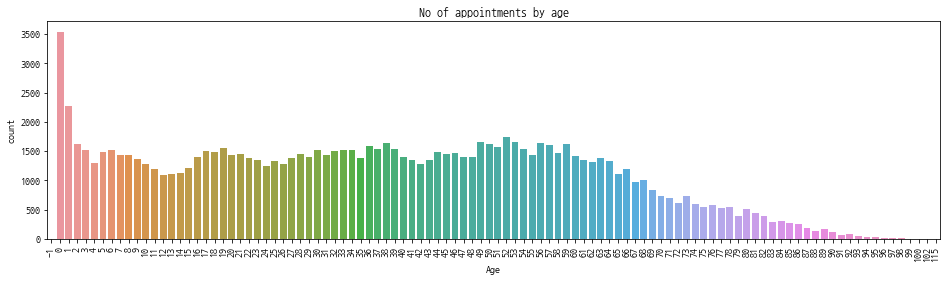

In [89]:
# Age 분포 
plt.figure(figsize=(16,4))
plt.xticks(rotation=90)
ax = sns.countplot(x=df.Age)
ax.set_title("No of appointments by age")
plt.show()

## 데이터 전처리 - Neighbourhood 열 제거 

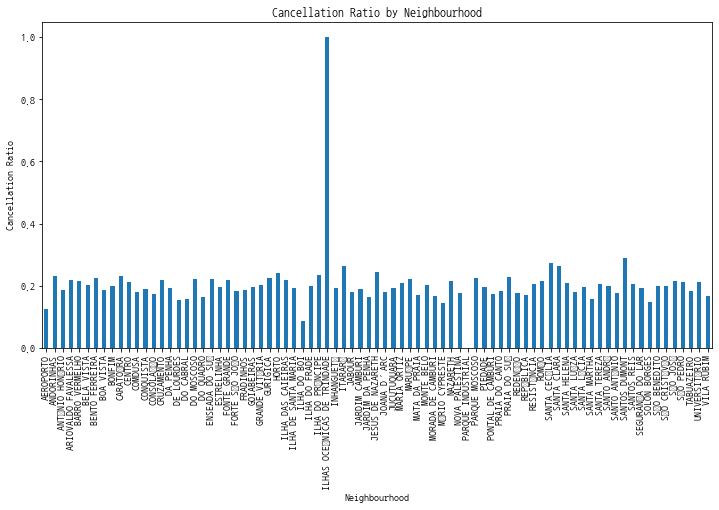

In [46]:
# Neighbourhood 그룹별로 'No-show' 열에서 'Yes' 비율 계산하기
cancelled_ratio = df.groupby('Neighbourhood')['No-show'].value_counts(normalize=True).unstack()['Yes']

# 시각화하기
plt.figure(figsize=(12, 6))
cancelled_ratio.plot(kind='bar')
plt.xlabel('Neighbourhood')
plt.ylabel('Cancellation Ratio')
plt.title('Cancellation Ratio by Neighbourhood')
plt.xticks(rotation=90)
plt.show()

- 지역별 병원 노쇼 비율을 살펴보았을 때, 'ILHAS OCEÂNICAS DE TRINDADE' 지역은 노쇼가 100%, 'PARQUE INDUSTRIAL'은 노쇼 확률이 0%로 나타났음.


In [47]:
df[df['Neighbourhood'] == 'ILHAS OCEÂNICAS DE TRINDADE']

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
48754,5.349869e+11,5583947,F,2016-04-14T12:25:43Z,2016-05-13T00:00:00Z,51,ILHAS OCEÂNICAS DE TRINDADE,0,0,0,0,0,0,Yes
48765,7.256430e+12,5583948,F,2016-04-14T12:26:13Z,2016-05-13T00:00:00Z,58,ILHAS OCEÂNICAS DE TRINDADE,0,0,0,0,0,0,Yes


In [48]:
df[df['Neighbourhood'] == 'PARQUE INDUSTRIAL']

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
75199,8.255992e+12,5663947,F,2016-05-05T10:48:59Z,2016-05-05T00:00:00Z,17,PARQUE INDUSTRIAL,0,0,0,0,0,0,No


In [49]:
df = df.drop('Neighbourhood', axis=1) # Neighbourhood 열 제거

<br>

- 해당 지역에 있는 사람들을 추출해 보았을 때, 'ILHAS OCEÂNICAS DE TRINDADE'은 2명 , 'PARQUE INDUSTRIAL' 은 1명으로 나타남 <br><br>

    
    
- 두 지역을 제외하고는 대부분의 지역별 노쇼비율은 0.2 로 비슷하여 노쇼를 예측하는데 중요한 변수가 아니라고 생각되어 해당 열 삭제

## 데이터 전처리 - AwaitingTime 열 생성

In [90]:
# ScheduledDay,AppointmentDay datetime 형식 변환
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'])
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype              
---  ------          --------------   -----              
 0   PatientId       110527 non-null  float64            
 1   AppointmentID   110527 non-null  int64              
 2   Gender          110527 non-null  object             
 3   ScheduledDay    110527 non-null  datetime64[ns, UTC]
 4   AppointmentDay  110527 non-null  datetime64[ns, UTC]
 5   Age             110527 non-null  int64              
 6   Neighbourhood   110527 non-null  object             
 7   Scholarship     110527 non-null  int64              
 8   Hipertension    110527 non-null  int64              
 9   Diabetes        110527 non-null  int64              
 10  Alcoholism      110527 non-null  int64              
 11  Handcap         110527 non-null  int64              
 12  SMS_received    110527 non-null  int64              
 13  No-show       

In [91]:
# AppointmentDay - ScheduledDay 값을 계산하여 새로운 열 생성
df['AwaitingTime'] = (pd.to_datetime(df['AppointmentDay']).dt.date - pd.to_datetime(df['ScheduledDay']).dt.date).dt.days
df

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,AwaitingTime
0,2.987250e+13,5642903,F,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,JARDIM DA PENHA,0,1,0,0,0,0,No,0
1,5.589978e+14,5642503,M,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,0,0,0,0,0,No,0
2,4.262962e+12,5642549,F,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,MATA DA PRAIA,0,0,0,0,0,0,No,0
3,8.679512e+11,5642828,F,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,0
4,8.841186e+12,5642494,F,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,1,1,0,0,0,No,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110522,2.572134e+12,5651768,F,2016-05-03 09:15:35+00:00,2016-06-07 00:00:00+00:00,56,MARIA ORTIZ,0,0,0,0,0,1,No,35
110523,3.596266e+12,5650093,F,2016-05-03 07:27:33+00:00,2016-06-07 00:00:00+00:00,51,MARIA ORTIZ,0,0,0,0,0,1,No,35
110524,1.557663e+13,5630692,F,2016-04-27 16:03:52+00:00,2016-06-07 00:00:00+00:00,21,MARIA ORTIZ,0,0,0,0,0,1,No,41
110525,9.213493e+13,5630323,F,2016-04-27 15:09:23+00:00,2016-06-07 00:00:00+00:00,38,MARIA ORTIZ,0,0,0,0,0,1,No,41


In [ ]:
x = df.loc[:, df.columns != 'No-show']
y = df[['No-show']]   

x_train, x_test, y_train,y_test = train_test_split(
    x, y, train_size=0.8, shuffle=True, random_state=42
)     

In [69]:
df['Handcap'].value_counts()

0    108282
1      2038
2       183
3        13
4         3
Name: Handcap, dtype: int64

In [ ]:
df['DateDifference'].value_counts().sort_index()